
# DATA 602 Classification Project: Chicago Energy Data - Continued



In the file named 'Chicago_Energy',I performed Exploratory data analysis on the dataset (can be found in the 'Data' folder in the repository). In this notebook, I will continue working on the same dataset. I will be doing preliminary feature engineering which will be followed by buidling machine learning models for my classification problem and evaluating them. Based on these evelaution metrics, I will pick the best model for my classification problem.

## Importing Libraries and Loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

energy = pd.read_csv('Energy_Usage_2010.csv') # original complete data
energy_new = pd.read_csv('Energy_post_EDA.csv') # processed data from EDA 

## Data Cleaning and Feature Engineering

I will be handeling outliers and doing some feature selection based on the correlation of features in the dataset. I also remove null values in the target variable as this could cause issues while building models. 

### Handeling outliers

Here I will be caping the ouliers with the 97 percentile value as the upper limit and 3 percentile value as the lower limit for the numerical columns. Below is an example of a numerical column 'ELECTRICITY ACCOUNTS'. We see how this effects the outliers and the distribution by looking at the box plots plotted before and after the capping process.

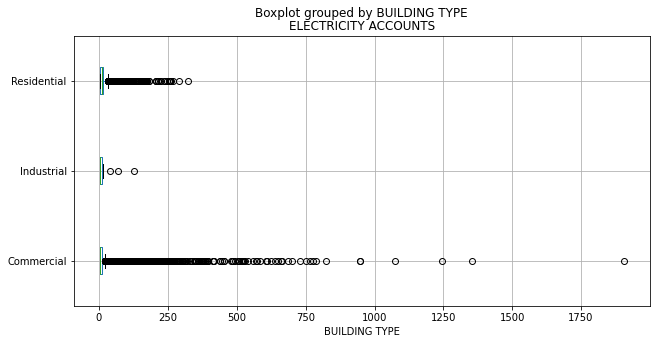

In [2]:
energy_new.boxplot(column='ELECTRICITY ACCOUNTS', by='BUILDING TYPE', vert=False, showfliers=True, figsize = (10,5))
plt.show()

In [3]:
numerical_features = energy_new.select_dtypes(exclude = 'object').columns.to_list()
print(numerical_features)

# Here I am capping the numerical features
for feature in numerical_features:
  #energy_new.boxplot(column='TOTAL KWH', by='BUILDING TYPE', vert=False, showfliers=True, figsize = (10,5))
  #plt.show()
  lower_limit = energy_new[f"{feature}"].quantile(0.03)  
  upper_limit = energy_new[f"{feature}"].quantile(0.97)
  energy_new[f"{feature}"] = np.where(energy_new[f"{feature}"]> upper_limit, upper_limit,
                          np.where(energy_new[f"{feature}"]< lower_limit, lower_limit,
                          energy_new[f"{feature}"]))

  #energy_new.boxplot(column='TOTAL_KWH_capped', by='BUILDING TYPE', vert=False, showfliers=True, figsize = (10,5))
  #plt.show()

['Unnamed: 0', 'TOTAL KWH', 'ELECTRICITY ACCOUNTS', 'ZERO KWH ACCOUNTS', 'TOTAL THERMS', 'GAS ACCOUNTS', 'KWH TOTAL SQFT', 'THERMS TOTAL SQFT', 'KWH MEAN 2010', 'KWH STANDARD DEVIATION 2010', 'KWH MINIMUM 2010', 'KWH 1ST QUARTILE 2010', 'KWH 2ND QUARTILE 2010', 'KWH 3RD QUARTILE 2010', 'KWH MAXIMUM 2010', 'KWH SQFT MEAN 2010', 'KWH SQFT STANDARD DEVIATION 2010', 'KWH SQFT MINIMUM 2010', 'KWH SQFT 1ST QUARTILE 2010', 'KWH SQFT 2ND QUARTILE 2010', 'KWH SQFT 3RD QUARTILE 2010', 'KWH SQFT MAXIMUM 2010', 'THERM MEAN 2010', 'THERM STANDARD DEVIATION 2010', 'THERM MINIMUM 2010', 'THERM 1ST QUARTILE 2010', 'THERM 2ND QUARTILE 2010', 'THERM 3RD QUARTILE 2010', 'THERM MAXIMUM 2010', 'THERMS SQFT MEAN 2010', 'THERMS SQFT STANDARD DEVIATION 2010', 'THERMS SQFT MINIMUM 2010', 'THERMS SQFT 1ST QUARTILE 2010', 'THERMS SQFT 2ND QUARTILE 2010', 'THERMS SQFT 3RD QUARTILE 2010', 'THERMS SQFT MAXIMUM 2010', 'TOTAL POPULATION', 'TOTAL UNITS', 'AVERAGE STORIES', 'AVERAGE BUILDING AGE', 'AVERAGE HOUSESIZE', 

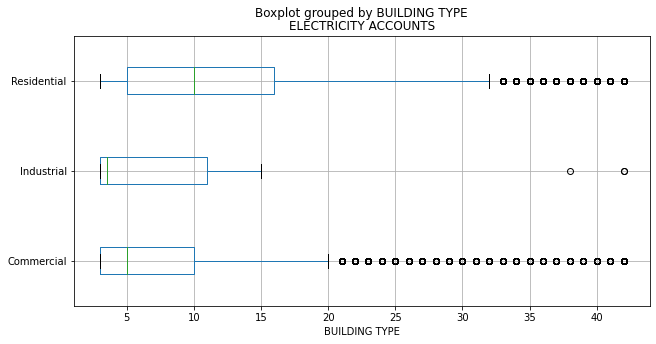

In [4]:
energy_new.boxplot(column='ELECTRICITY ACCOUNTS', by='BUILDING TYPE', vert=False, showfliers=True, figsize = (10,5))
plt.show()

### Feature Selection
Removing redundant features based on the correlation.

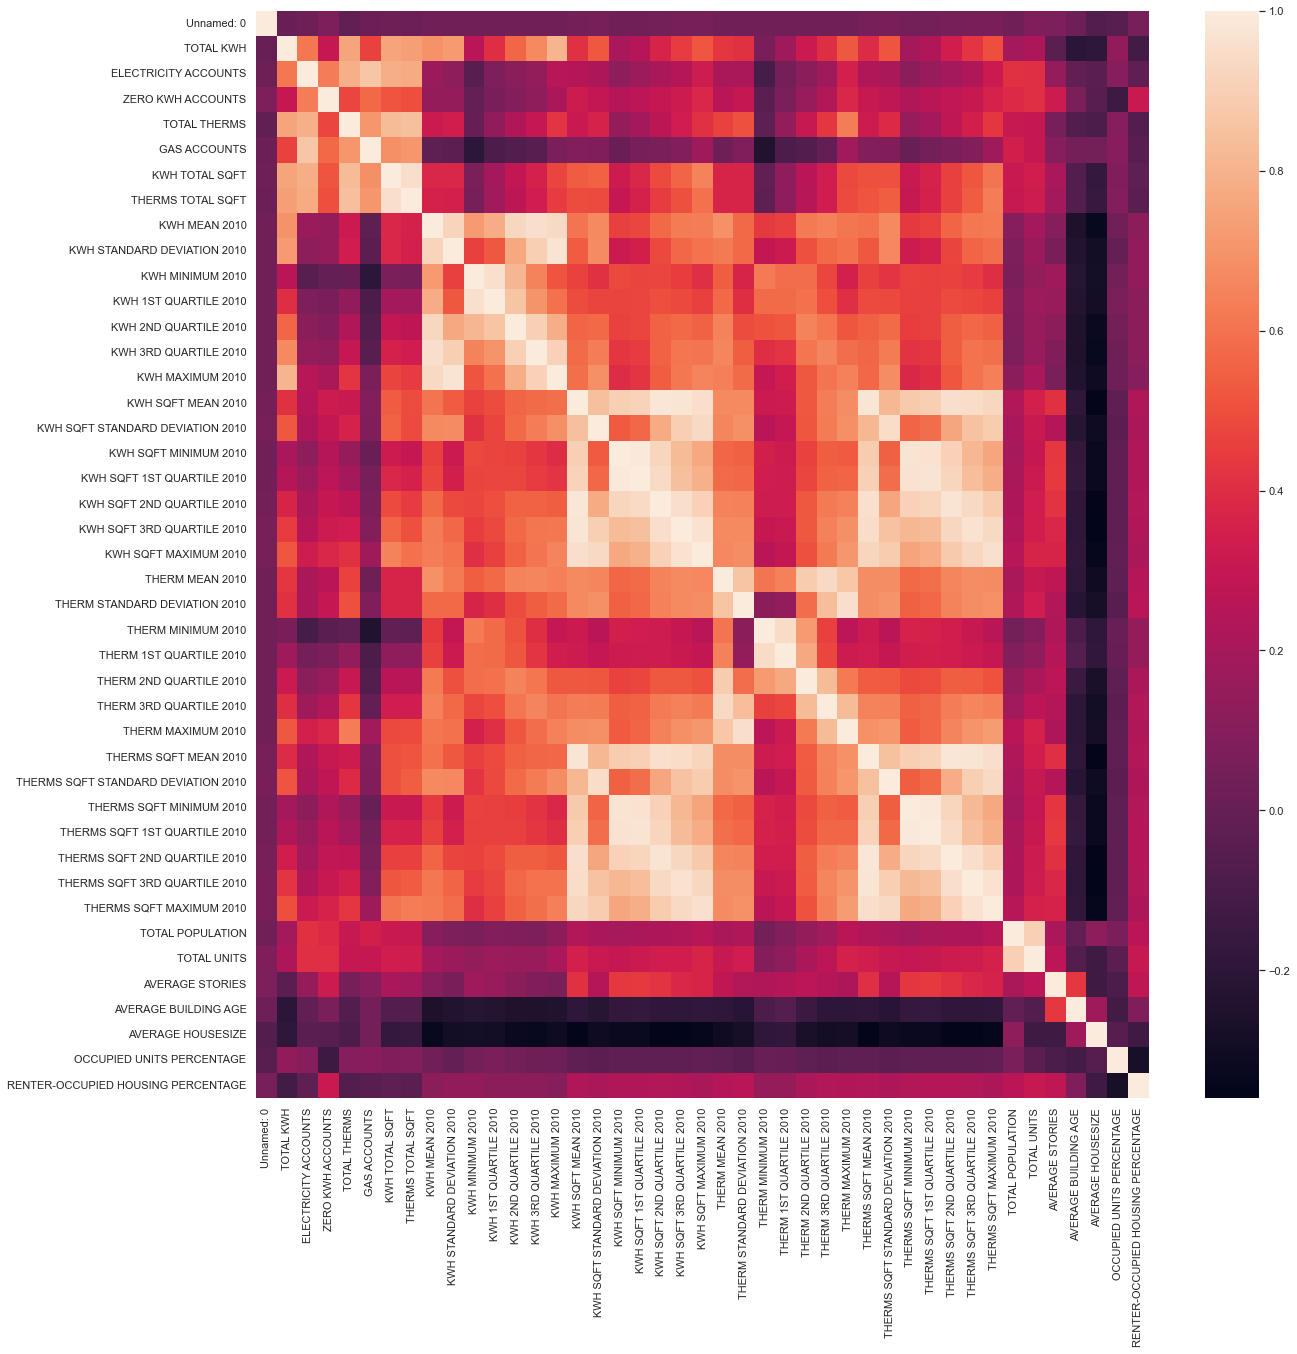

In [5]:
#https://machinelearningmastery.com/an-introduction-to-feature-selection/
#https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

correlation_martix = energy_new.corr()
sns.set(rc = {'figure.figsize':(20,20)})
sns.heatmap(correlation_martix, annot = False)
plt.show()

Here I remove the columns that show more than 0.9 correlation factor with other columns.  

In [6]:
#Reference: https://stackabuse.com/applying-filter-methods-in-python-for-feature-selection/
correlated_features = set()
for i in range(len(correlation_martix.columns)):
    for j in range(i):
        if abs(correlation_martix.iloc[i, j]) > 0.90:
            colname = correlation_martix.columns[i]
            correlated_features.add(colname)
print(correlated_features)
print(len(correlated_features))

{'KWH SQFT MAXIMUM 2010', 'KWH SQFT 2ND QUARTILE 2010', 'THERM 1ST QUARTILE 2010', 'THERMS TOTAL SQFT', 'KWH 1ST QUARTILE 2010', 'KWH MAXIMUM 2010', 'THERMS SQFT MEAN 2010', 'KWH 3RD QUARTILE 2010', 'KWH SQFT 1ST QUARTILE 2010', 'KWH 2ND QUARTILE 2010', 'KWH STANDARD DEVIATION 2010', 'KWH SQFT 3RD QUARTILE 2010', 'THERMS SQFT 3RD QUARTILE 2010', 'THERMS SQFT STANDARD DEVIATION 2010', 'THERM MAXIMUM 2010', 'THERMS SQFT 2ND QUARTILE 2010', 'THERMS SQFT MAXIMUM 2010', 'THERMS SQFT 1ST QUARTILE 2010', 'THERMS SQFT MINIMUM 2010', 'THERM 3RD QUARTILE 2010', 'TOTAL UNITS'}
21


In [7]:
energy_new.drop(labels=correlated_features, axis=1, inplace=True)

## Modeling

Since this is a classifcation problem where the target variable is the 'BUILDING TYPE', we will be modeling some of the standard classifiers before evaluating and finding the best model.
These include:
1. Logistic Regression (with and without PCA)
2. Decision Tree (with and without PCA)
3. Random Forest
4. Stochastic Gradient Descent Classifier 

For all these models, I will be usign GridSearchCV to perform cross-validation and hyperparameter tuning. The model with the best parameters optimized for the precision-macro score will be chosen for futher model evaluation. I also compare the recall, f1 score and the roc_auc scores to comapre the different models. 

In [8]:
energy_new.columns

Index(['Unnamed: 0', 'COMMUNITY AREA NAME', 'BUILDING TYPE', 'TOTAL KWH',
       'ELECTRICITY ACCOUNTS', 'ZERO KWH ACCOUNTS', 'TOTAL THERMS',
       'GAS ACCOUNTS', 'KWH TOTAL SQFT', 'KWH MEAN 2010', 'KWH MINIMUM 2010',
       'KWH SQFT MEAN 2010', 'KWH SQFT STANDARD DEVIATION 2010',
       'KWH SQFT MINIMUM 2010', 'THERM MEAN 2010',
       'THERM STANDARD DEVIATION 2010', 'THERM MINIMUM 2010',
       'THERM 2ND QUARTILE 2010', 'TOTAL POPULATION', 'AVERAGE STORIES',
       'AVERAGE BUILDING AGE', 'AVERAGE HOUSESIZE',
       'OCCUPIED UNITS PERCENTAGE', 'RENTER-OCCUPIED HOUSING PERCENTAGE'],
      dtype='object')

In [9]:
energy_new.drop('Unnamed: 0', axis = 1, inplace = True)

In [10]:
energy_new

,COMMUNITY AREA NAME,BUILDING TYPE,TOTAL KWH,ELECTRICITY ACCOUNTS,ZERO KWH ACCOUNTS,TOTAL THERMS,GAS ACCOUNTS,KWH TOTAL SQFT,KWH MEAN 2010,KWH MINIMUM 2010,...,THERM MEAN 2010,THERM STANDARD DEVIATION 2010,THERM MINIMUM 2010,THERM 2ND QUARTILE 2010,TOTAL POPULATION,AVERAGE STORIES,AVERAGE BUILDING AGE,AVERAGE HOUSESIZE,OCCUPIED UNITS PERCENTAGE,RENTER-OCCUPIED HOUSING PERCENTAGE
0,Archer Heights,Residential,NaN,NaN,0.0,10917.0,11.0,NaN,NaN,NaN,...,1819.5000,547.64,1061.0,1864.5,89.0,2.00,71.33,3.87,0.9582,0.3910
1,Ashburn,Residential,82064.0,8.0,3.0,NaN,NaN,10892.0,27354.67,8886.0,...,NaN,NaN,NaN,NaN,112.0,2.00,41.00,1.81,0.9254,0.8059
2,Auburn Gresham,Commercial,NaN,NaN,7.0,6057.0,4.0,NaN,NaN,NaN,...,3028.5000,4150.01,94.0,3028.5,102.0,3.00,86.00,3.00,0.7082,0.6759
3,Austin,Commercial,NaN,NaN,2.0,1431.0,3.0,NaN,NaN,NaN,...,843.0868,NaN,400.0,474.0,121.0,2.00,84.00,2.95,0.7321,0.7800
4,Austin,Commercial,NaN,NaN,3.0,1431.0,3.0,NaN,NaN,NaN,...,949.0000,NaN,949.0,949.0,62.0,2.00,85.00,3.26,0.8261,0.5790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67046,Woodlawn,Residential,27654.0,6.0,7.0,10769.0,9.0,7801.0,6913.50,2444.0,...,2692.2500,3661.92,272.0,1195.5,116.0,1.00,0.00,3.14,0.6727,0.7030
67047,Woodlawn,Commercial,41977.0,9.0,5.0,7726.0,8.0,11838.0,13992.33,10754.0,...,2575.3300,3492.97,57.0,1124.0,31.0,3.00,104.50,2.07,0.6250,0.8670
67048,Woodlawn,Residential,48850.0,7.0,2.0,10293.0,5.0,11028.0,16283.33,7010.0,...,3431.0000,1155.32,2449.0,3140.0,31.0,2.33,100.67,2.07,0.6250,0.8670
67049,Woodlawn,Residential,17707.0,7.0,9.0,1431.0,5.0,4653.0,4426.75,1878.0,...,843.0868,110.34,57.0,474.0,0.0,1.00,0.00,0.00,NaN,NaN


In [11]:
energy_new['BUILDING TYPE'].value_counts(dropna = False)

Residential    49747
Commercial     17185
NaN               77
Industrial        42
Name: BUILDING TYPE, dtype: int64

The following step of dropping the rows with NaN values in the target variable is because of an error that occured during the pipeline building process despite including the simple imputer. This will be discussed under the pipeline building section. 

In [12]:
energy_new_test = energy_new[energy_new['BUILDING TYPE'].notna()]
energy_new_test

,COMMUNITY AREA NAME,BUILDING TYPE,TOTAL KWH,ELECTRICITY ACCOUNTS,ZERO KWH ACCOUNTS,TOTAL THERMS,GAS ACCOUNTS,KWH TOTAL SQFT,KWH MEAN 2010,KWH MINIMUM 2010,...,THERM MEAN 2010,THERM STANDARD DEVIATION 2010,THERM MINIMUM 2010,THERM 2ND QUARTILE 2010,TOTAL POPULATION,AVERAGE STORIES,AVERAGE BUILDING AGE,AVERAGE HOUSESIZE,OCCUPIED UNITS PERCENTAGE,RENTER-OCCUPIED HOUSING PERCENTAGE
0,Archer Heights,Residential,NaN,NaN,0.0,10917.0,11.0,NaN,NaN,NaN,...,1819.5000,547.64,1061.0,1864.5,89.0,2.00,71.33,3.87,0.9582,0.3910
1,Ashburn,Residential,82064.0,8.0,3.0,NaN,NaN,10892.0,27354.67,8886.0,...,NaN,NaN,NaN,NaN,112.0,2.00,41.00,1.81,0.9254,0.8059
2,Auburn Gresham,Commercial,NaN,NaN,7.0,6057.0,4.0,NaN,NaN,NaN,...,3028.5000,4150.01,94.0,3028.5,102.0,3.00,86.00,3.00,0.7082,0.6759
3,Austin,Commercial,NaN,NaN,2.0,1431.0,3.0,NaN,NaN,NaN,...,843.0868,NaN,400.0,474.0,121.0,2.00,84.00,2.95,0.7321,0.7800
4,Austin,Commercial,NaN,NaN,3.0,1431.0,3.0,NaN,NaN,NaN,...,949.0000,NaN,949.0,949.0,62.0,2.00,85.00,3.26,0.8261,0.5790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67046,Woodlawn,Residential,27654.0,6.0,7.0,10769.0,9.0,7801.0,6913.50,2444.0,...,2692.2500,3661.92,272.0,1195.5,116.0,1.00,0.00,3.14,0.6727,0.7030
67047,Woodlawn,Commercial,41977.0,9.0,5.0,7726.0,8.0,11838.0,13992.33,10754.0,...,2575.3300,3492.97,57.0,1124.0,31.0,3.00,104.50,2.07,0.6250,0.8670
67048,Woodlawn,Residential,48850.0,7.0,2.0,10293.0,5.0,11028.0,16283.33,7010.0,...,3431.0000,1155.32,2449.0,3140.0,31.0,2.33,100.67,2.07,0.6250,0.8670
67049,Woodlawn,Residential,17707.0,7.0,9.0,1431.0,5.0,4653.0,4426.75,1878.0,...,843.0868,110.34,57.0,474.0,0.0,1.00,0.00,0.00,NaN,NaN


In [13]:
energy_new_test['BUILDING TYPE'].value_counts(dropna = False)

Residential    49747
Commercial     17185
Industrial        42
Name: BUILDING TYPE, dtype: int64

Here, I am combining Industrial and Commercial values into a class named 'Non-Residential'. Finally, my target variable will have 'Residential' and 'Non-Residential' values.

In [14]:
energy_new_test['BUILDING TYPE'].replace('Industrial', 'Non-Residential', inplace =True)
energy_new_test['BUILDING TYPE'].replace('Commercial', 'Non-Residential', inplace =True)

C:\Users\rjala\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


### Train-Test data splitting
> Here we will split the data into train and test data before modeling.

In [15]:
from sklearn.model_selection import train_test_split

targetCol = 'BUILDING TYPE'
featureCols = [x for x in energy_new_test.columns if x != targetCol]

y = energy_new_test[targetCol]
X = energy_new_test[featureCols]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)

print(f'Target: {targetCol}')
print('Features:')
print(*featureCols, sep=',\t')
print('\n')
print(f'Training examples: {x_train.shape[0]}')
print(f'Test examples: {x_test.shape[0]:,}')

Target: BUILDING TYPE
Features:
COMMUNITY AREA NAME,	TOTAL KWH,	ELECTRICITY ACCOUNTS,	ZERO KWH ACCOUNTS,	TOTAL THERMS,	GAS ACCOUNTS,	KWH TOTAL SQFT,	KWH MEAN 2010,	KWH MINIMUM 2010,	KWH SQFT MEAN 2010,	KWH SQFT STANDARD DEVIATION 2010,	KWH SQFT MINIMUM 2010,	THERM MEAN 2010,	THERM STANDARD DEVIATION 2010,	THERM MINIMUM 2010,	THERM 2ND QUARTILE 2010,	TOTAL POPULATION,	AVERAGE STORIES,	AVERAGE BUILDING AGE,	AVERAGE HOUSESIZE,	OCCUPIED UNITS PERCENTAGE,	RENTER-OCCUPIED HOUSING PERCENTAGE


Training examples: 53579
Test examples: 13,395


### Building Pre-processing Pipelines

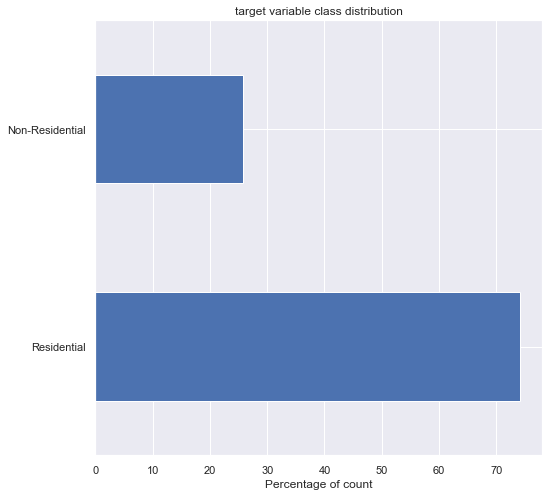

In [16]:
plt.figure(figsize=(8,8))
(y_train.value_counts()*100/len(y_train)).plot.barh()
plt.title('target variable class distribution')
plt.xlabel('Percentage of count')
plt.show()

> As our target data is imbalanced, we will be using precision, recall and f1 score as the metrics to evaluate and compare different models. We will also compare the roc_auc scores for different models. 

> There are no NaN values in y_train or y_test. This is because we removed them from the target variable column in the main dataframe. This was done beacuse this led to an error while building pipeline and model. Despite including the simple imputer, the error said that there were NaN's in the data. When the NaN values in the target variable was removed, the error got resolved. Does this mean that the pipeline does not process the target variable data? Yes, the pipelines do not transform the target variable.

In [17]:
(y_train.value_counts(dropna = False)*100/len(y_train))

Residential        74.210045
Non-Residential    25.789955
Name: BUILDING TYPE, dtype: float64

In [18]:
y_train.unique()

array(['Non-Residential', 'Residential'], dtype=object)

In [19]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53579 entries, 13702 to 15741
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   COMMUNITY AREA NAME                 53579 non-null  object 
 1   TOTAL KWH                           52883 non-null  float64
 2   ELECTRICITY ACCOUNTS                52883 non-null  float64
 3   ZERO KWH ACCOUNTS                   53579 non-null  float64
 4   TOTAL THERMS                        52544 non-null  float64
 5   GAS ACCOUNTS                        52544 non-null  float64
 6   KWH TOTAL SQFT                      52660 non-null  float64
 7   KWH MEAN 2010                       52883 non-null  float64
 8   KWH MINIMUM 2010                    52883 non-null  float64
 9   KWH SQFT MEAN 2010                  52660 non-null  float64
 10  KWH SQFT STANDARD DEVIATION 2010    41297 non-null  float64
 11  KWH SQFT MINIMUM 2010               5

In [20]:
numerical_features = X.select_dtypes(exclude = 'object').columns.to_list()
categorical_features = X.select_dtypes(include = 'object').columns.to_list()

print('Number of numerical features: ', len(numerical_features))
print('Number of categorical features: ',len(categorical_features))
print(numerical_features)
print(categorical_features)

Number of numerical features:  21
Number of categorical features:  1
['TOTAL KWH', 'ELECTRICITY ACCOUNTS', 'ZERO KWH ACCOUNTS', 'TOTAL THERMS', 'GAS ACCOUNTS', 'KWH TOTAL SQFT', 'KWH MEAN 2010', 'KWH MINIMUM 2010', 'KWH SQFT MEAN 2010', 'KWH SQFT STANDARD DEVIATION 2010', 'KWH SQFT MINIMUM 2010', 'THERM MEAN 2010', 'THERM STANDARD DEVIATION 2010', 'THERM MINIMUM 2010', 'THERM 2ND QUARTILE 2010', 'TOTAL POPULATION', 'AVERAGE STORIES', 'AVERAGE BUILDING AGE', 'AVERAGE HOUSESIZE', 'OCCUPIED UNITS PERCENTAGE', 'RENTER-OCCUPIED HOUSING PERCENTAGE']
['COMMUNITY AREA NAME']


#### Let's start building the basic **pre-processing pipelines**.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# pipeline for numerical data
num_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy  = 'median')),
                          ('standardize', StandardScaler())])
x_train_num = num_pipeline.fit_transform(x_train[numerical_features])
x_train_num.shape

(53579, 21)

In [22]:
# pipeline for categorical data
cat_pipeline = Pipeline([('impute_missing_cats', SimpleImputer(strategy = 'most_frequent')), 
                         ('dummy_encoding', OneHotEncoder(handle_unknown = 'error', drop = 'first', sparse = False))])
x_train_cat = cat_pipeline.fit_transform(x_train[categorical_features])
x_train_cat.shape

(53579, 76)

In [23]:
x_train['COMMUNITY AREA NAME'].nunique() - 1

76

In [24]:
# Creating the processing pipeline
Processing_pipeline = ColumnTransformer(transformers = [('num', num_pipeline, numerical_features), 
                                                  ('cat', cat_pipeline, categorical_features)])
x_train_transformed = Processing_pipeline.fit_transform(x_train)
x_train_transformed.shape

(53579, 97)

### Determining PCA components

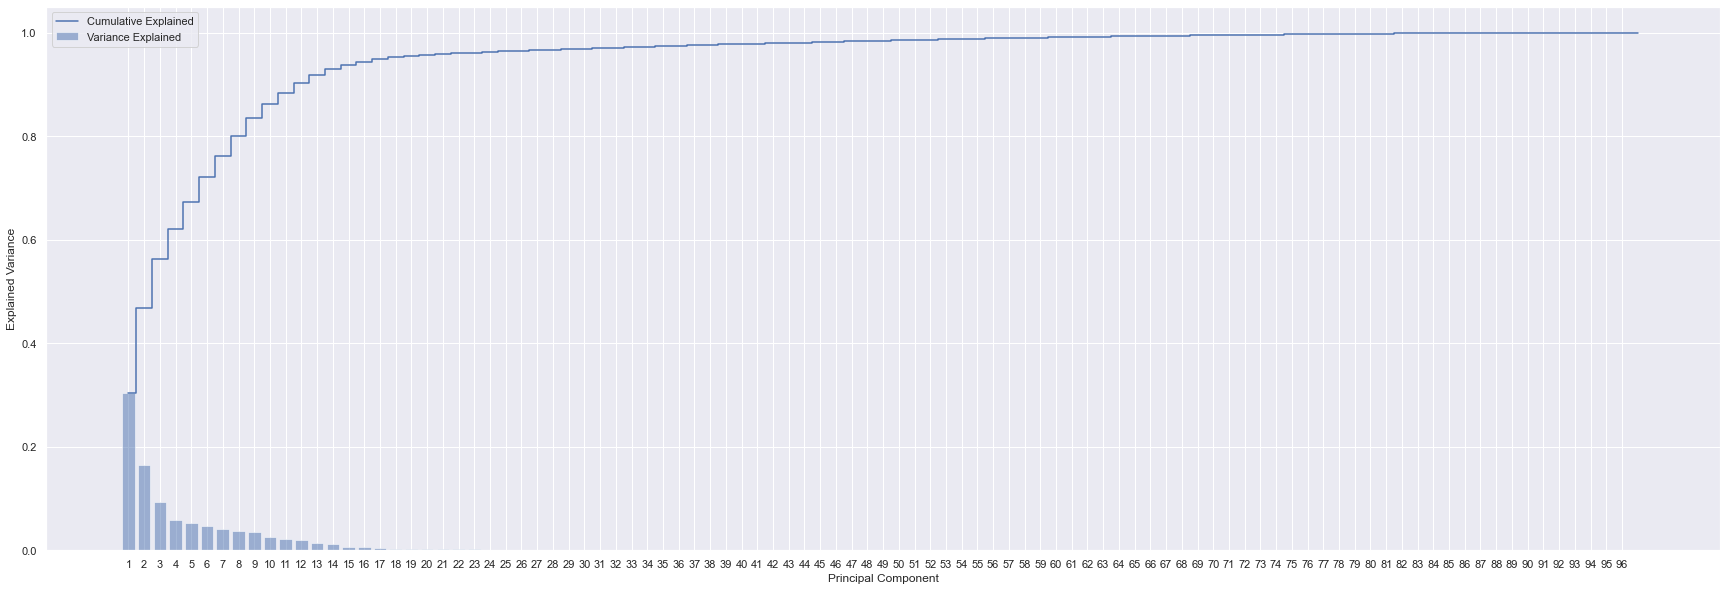

In [25]:
cov_mat = np.cov(x_train_transformed.T)

eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
tot = sum(eigen_vals)

var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

bars = [i for i in range(1, 97)]
plt.figure(figsize=(30,10))
plt.bar(range(1,98), var_exp, alpha=0.5,align='center', label='Variance Explained')
plt.xticks(bars)
plt.step(range(1,98), cum_var_exp, where='mid', label='Cumulative Explained')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.legend()
plt.show()

From the explained variance curve, it looks like the first ~20 components explain nearly 90% of the data. We will use this inuput to chose parameter values when performing the GridSearcgCV when building models.

### **1. Logistic Regression with PCA**

The most basic classification model is the Logistic regression. So I will use this model first. I also include PCA as a pre-processing step to see if there is any improvement in the model performance in terms of runtime. However, we see that including PCA in the GridSearchCV is computationally inefficient and takes longer than without the preprocessign step. 

#### Primary Search: Logistic Regression with PCA

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD

In [27]:
%%time
lgr_pipeline = Pipeline([('data_processing', Processing_pipeline), 
                          ('pca', PCA()),
                          ('model', LogisticRegression(max_iter = 5000, solver = 'sag'))])

param_grid_lgr = [{'model__penalty': ['none'], 'pca__n_components': [30,40,50,60,70,80,90]}, {'model__C': [0.01, 0.1, 1, 10], 'model__penalty': ['l2'], 'pca__n_components': [30,40,50,60,70,80,90]}]

gs_lgr = GridSearchCV(lgr_pipeline, param_grid = param_grid_lgr, scoring='precision_macro', cv = 6, refit=True)
gs_lgr = gs_lgr.fit(x_train, y_train)

gs_lgr.best_estimator_

Wall time: 6min 34s


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['TOTAL KWH',
                                                   'ELECTRICITY ACCOUNTS',
                                                   'ZERO KWH ACCOUNTS',
                                                   'TOTAL THERMS',
                                                   'GAS ACCOUNTS',
                                                   'KWH TOTAL SQFT',
                                                   'KWH MEAN 2010',
                                                   'KWH MINIMUM 2010

> Now I will do a secondary search around n_components = 80 to find the best n_components parameter for performing the pca. Apart from this, we also search around the C parmeter 0.1 to find the best C value.
> However, the first search took around 6 minutes to run. I will therefore use the runtime as one of the metrics to determine the best model. 

#### Secondary Search: Logistic Regression with PCA

In [28]:
%%time
lgr_pipeline_2 = Pipeline([('data_processing', Processing_pipeline), 
                          ('pca', PCA()),
                          ('model', LogisticRegression(max_iter = 5000, solver = 'sag'))])

param_grid_lgr_2 = [{'model__penalty': ['none'], 'pca__n_components': [78,79,80,81,82,83]}, {'model__C': [0.99,0.1, 0.2, 0.3], 'model__penalty': ['l2'], 'pca__n_components': [78,79,80,81,82,83]}]

gs_lgr_2 = GridSearchCV(lgr_pipeline_2, param_grid = param_grid_lgr_2, scoring='precision_macro', cv = 6, refit=True)
gs_lgr_2 = gs_lgr_2.fit(x_train, y_train)

Wall time: 4min 51s


In [29]:
gs_lgr_2.best_estimator_

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['TOTAL KWH',
                                                   'ELECTRICITY ACCOUNTS',
                                                   'ZERO KWH ACCOUNTS',
                                                   'TOTAL THERMS',
                                                   'GAS ACCOUNTS',
                                                   'KWH TOTAL SQFT',
                                                   'KWH MEAN 2010',
                                                   'KWH MINIMUM 2010

In [30]:
gs_lgr_2.best_params_

{'model__C': 0.1, 'model__penalty': 'l2', 'pca__n_components': 80}

> The best parameters for logistic regression with PCA are regularization strength C value 0.1 with 'l2' penalty run on 80 PCA components. 

In [31]:
from sklearn.metrics import classification_report

y_hat_test = gs_lgr_2.predict(x_test) 
y_hat_train = gs_lgr_2.predict(x_train) 

# Evaluating the performance
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_hat_test), '\n')

print(f'Precision macro score for validation data: {gs_lgr_2.best_score_:.2%}')
print(f'Precision macro score for train data: {gs_lgr_2.score(x_train, y_train):.2%}')
print(f'Precision macro score for test data: {gs_lgr_2.score(x_test, y_test):.2%}', '\n')
print(classification_report(y_test, y_hat_test))

[[1919 1490]
 [ 766 9220]] 

Precision macro score for validation data: 79.41%
Precision macro score for train data: 79.52%
Precision macro score for test data: 78.78% 

                 precision    recall  f1-score   support

Non-Residential       0.71      0.56      0.63      3409
    Residential       0.86      0.92      0.89      9986

       accuracy                           0.83     13395
      macro avg       0.79      0.74      0.76     13395
   weighted avg       0.82      0.83      0.82     13395



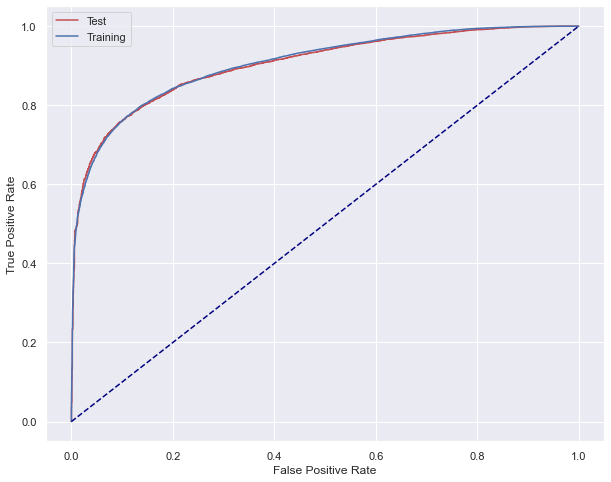

In [96]:
from sklearn.metrics import roc_curve

def generate_probs(X, model=gs_lgr_2.best_estimator_):
    return model.predict_proba(X)[:, 1]

def generate_roc(y, probs):
    fpr, tpr, _ = roc_curve(y, probs, pos_label = 'Residential')
    return fpr, tpr
    
fpr_test, tpr_test = generate_roc(y_test, generate_probs(x_test))
fpr_train, tpr_train = generate_roc(y_train, generate_probs(x_train))

plt.figure(figsize = (10,8))
plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

In [97]:
from sklearn.metrics import roc_auc_score

print(f'Area under the curve score: {roc_auc_score(y_test, generate_probs(x_test))}')
roc_auc = []
roc_auc.append(roc_auc_score(y_test, generate_probs(x_test)))

Area under the curve score: 0.903746177473338


This model gives a precison macro score of 79.41% on the train data and 78.78% on the test data. The f1 score obtained for this model is 0.76. I will now build the logistic regression model without PCA step to compare model performance.

### 2. Logistic Regression without PCA

Here a logistic regression model is built without using PCA as a pre-processign step. It is expected that this would give better reuslts, but might take longer time to run. However, GridSearchCV for the logistic regression model without PCA runs faster than the model without PCA.

#### Primary Search: Logistic Regression without PCA

In [34]:
%%time

lgr_no_pca_pipeline = Pipeline([('data_processing', Processing_pipeline), 
                        ('model', LogisticRegression(max_iter = 5000, solver = 'sag'))])

param_grid_lgr_no_pca = [{'model__penalty': ['none']}, {'model__C': [0.01, 0.1, 1, 10], 'model__penalty': ['l2']}]

gs_lgr_no_pca = GridSearchCV(lgr_no_pca_pipeline, param_grid = param_grid_lgr_no_pca, scoring='precision_macro', cv = 6, refit=True)
gs_lgr_no_pca = gs_lgr_no_pca.fit(x_train, y_train)

gs_lgr_no_pca.best_estimator_

Wall time: 2min 52s


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['TOTAL KWH',
                                                   'ELECTRICITY ACCOUNTS',
                                                   'ZERO KWH ACCOUNTS',
                                                   'TOTAL THERMS',
                                                   'GAS ACCOUNTS',
                                                   'KWH TOTAL SQFT',
                                                   'KWH MEAN 2010',
                                                   'KWH MINIMUM 2010

In [35]:
gs_lgr_no_pca.best_params_

{'model__C': 0.1, 'model__penalty': 'l2'}

#### Secondary Search: Logistic Regression without PCA

In [36]:
%%time

lgr_no_pca_pipeline_2 = Pipeline([('data_processing', Processing_pipeline), 
                        ('model', LogisticRegression(max_iter = 5000, solver = 'sag'))])

param_grid_lgr_no_pca_2 = [{'model__penalty': ['none']}, {'model__C': [0.09, 0.1, 0.2, 0.3], 'model__penalty': ['l2']}]

gs_lgr_no_pca_2 = GridSearchCV(lgr_no_pca_pipeline_2, param_grid = param_grid_lgr_no_pca_2, scoring='precision_macro', cv = 6, refit=True)
gs_lgr_no_pca_2 = gs_lgr_no_pca_2.fit(x_train, y_train)

gs_lgr_no_pca_2.best_estimator_

Wall time: 1min 49s


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['TOTAL KWH',
                                                   'ELECTRICITY ACCOUNTS',
                                                   'ZERO KWH ACCOUNTS',
                                                   'TOTAL THERMS',
                                                   'GAS ACCOUNTS',
                                                   'KWH TOTAL SQFT',
                                                   'KWH MEAN 2010',
                                                   'KWH MINIMUM 2010

In [37]:
gs_lgr_no_pca_2.best_params_

{'model__C': 0.2, 'model__penalty': 'l2'}

The best hyper-paraemters chosen for this model are regularization strength parameter 0.2 with 'l2' penalty.

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_hat_no_pca_test = gs_lgr_no_pca_2.predict(x_test) 
y_hat_no_pca_train = gs_lgr_no_pca_2.predict(x_train) 

# Evaluating the performance
print(confusion_matrix(y_test, y_hat_no_pca_test), '\n')

print(f'Precision macro score for validation data: {gs_lgr_no_pca_2.best_score_:.2%}')
print(f'Precision macro score for train data: {gs_lgr_no_pca_2.score(x_train, y_train):.2%}')
print(f'Precision macro score for test data: {gs_lgr_no_pca_2.score(x_test, y_test):.2%}', '\n')
print(classification_report(y_test, y_hat_no_pca_test))

[[1933 1476]
 [ 772 9214]] 

Precision macro score for validation data: 79.37%
Precision macro score for train data: 79.49%
Precision macro score for test data: 78.83% 

                 precision    recall  f1-score   support

Non-Residential       0.71      0.57      0.63      3409
    Residential       0.86      0.92      0.89      9986

       accuracy                           0.83     13395
      macro avg       0.79      0.74      0.76     13395
   weighted avg       0.82      0.83      0.83     13395



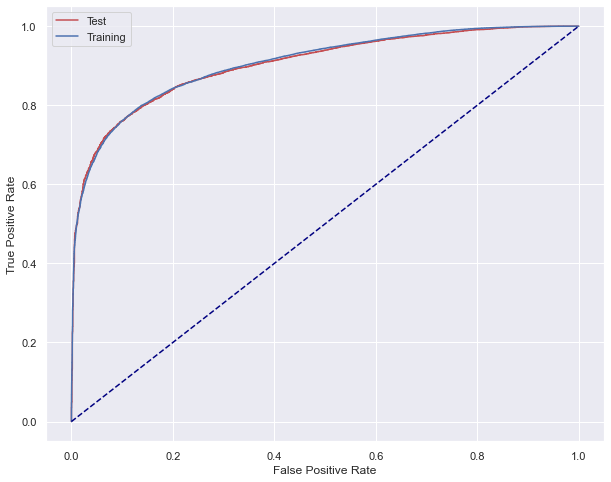

Area under the curve score: 0.9038135349007531


In [98]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def generate_probs(X, model=gs_lgr_no_pca_2.best_estimator_):
    return model.predict_proba(X)[:, 1]

def generate_roc(y, probs):
    fpr, tpr, _ = roc_curve(y, probs, pos_label = 'Residential')
    return fpr, tpr
    
fpr_test, tpr_test = generate_roc(y_test, generate_probs(x_test))
fpr_train, tpr_train = generate_roc(y_train, generate_probs(x_train))

plt.figure(figsize = (10,8))
plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

print(f'Area under the curve score: {roc_auc_score(y_test, generate_probs(x_test))}')
roc_auc.append(roc_auc_score(y_test, generate_probs(x_test)))

Comparing logistic regression with and without PCA, the precision scores for train data are 79.41% and 79.37% respectively. For test data, the precision scores are the 78.78% and 78.83% for models with and without PCA. The f1 scores and the roc_auc_scores also are very similar. However, the logistic regression model without PCA takes only 2 minutes to run whereas the model with PCA takes nearly 6 minutes to run. Considering the runtime and the scores, the logistic regresion model without PCA is a better model.

### **3. Decision Tree without PCA**

The next model considered is the decision tree which is the another classifier model that is widely used. Again, I will run a GridSearch to find the best hyperparameters that optimizes the precision macro scores. 

#### Primary Search: Decision Tree without PCA

In [40]:
%%time

from sklearn.tree import DecisionTreeClassifier

tree_pipeline = Pipeline([('data_processing', Processing_pipeline),
                          ('decision_tree', DecisionTreeClassifier(criterion='gini', random_state=1))
                                ])

param_grid_tree = [
  {'decision_tree__max_depth': [3,6,9, 12, 14],
   'decision_tree__min_samples_split': [0.8, 2, 4, 6]
  }]

gs_tree = GridSearchCV(estimator=tree_pipeline, param_grid=param_grid_tree, scoring='precision_macro', refit = True)
gs_tree = gs_tree.fit(x_train, y_train)

Wall time: 1min 37s


In [41]:
gs_tree.best_params_

{'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}

#### Secondary Search: Decision Tree without PCA

In [42]:
%%time
tree_pipeline_2 = Pipeline([('data_processing', Processing_pipeline),
                          ('decision_tree', DecisionTreeClassifier(criterion='gini', random_state=1))
                                ])

param_grid_tree_2 = [
  {'decision_tree__max_depth': [2,3,4],
   'decision_tree__min_samples_split': [0.9,2,4,6]
  }]

gs_tree_2 = GridSearchCV(estimator=tree_pipeline_2, param_grid=param_grid_tree_2, scoring='precision_macro', refit = True)
gs_tree_2 = gs_tree_2.fit(x_train, y_train)

Wall time: 37.5 s


In [43]:
gs_tree_2.best_params_

{'decision_tree__max_depth': 3, 'decision_tree__min_samples_split': 2}

> The GridSearch for Decision tree gives maximum depth 3 for the tree and minimum sample split value 2 as the best parameters.  

In [44]:
y_hat_tree_test = gs_tree_2.predict(x_test) 
y_hat_tree_train = gs_tree_2.predict(x_train) 

# Evaluating the performance
print(confusion_matrix(y_test, y_hat_tree_test), '\n')

print(f'Precision macro score for validation data: {gs_tree_2.best_score_:.2%}')
print(f'Precision macro score for train data: {gs_tree_2.score(x_train, y_train):.2%}')
print(f'Precision macro score for test data: {gs_tree_2.score(x_test, y_test):.2%}', '\n')
print(classification_report(y_test, y_hat_tree_test))

[[1602 1807]
 [ 549 9437]] 

Precision macro score for validation data: 80.21%
Precision macro score for train data: 80.18%
Precision macro score for test data: 79.20% 

                 precision    recall  f1-score   support

Non-Residential       0.74      0.47      0.58      3409
    Residential       0.84      0.95      0.89      9986

       accuracy                           0.82     13395
      macro avg       0.79      0.71      0.73     13395
   weighted avg       0.82      0.82      0.81     13395



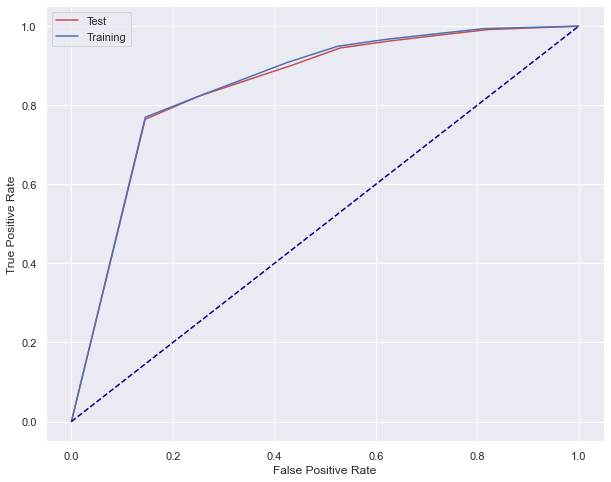

Area under the curve score: 0.8460237115769645


In [99]:
def generate_probs(X, model=gs_tree_2.best_estimator_):
    return model.predict_proba(X)[:, 1]

def generate_roc(y, probs):
    fpr, tpr, _ = roc_curve(y, probs, pos_label = 'Residential')
    return fpr, tpr
    
fpr_test, tpr_test = generate_roc(y_test, generate_probs(x_test))
fpr_train, tpr_train = generate_roc(y_train, generate_probs(x_train))

plt.figure(figsize = (10,8))
plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

print(f'Area under the curve score: {roc_auc_score(y_test, generate_probs(x_test))}')
roc_auc.append(roc_auc_score(y_test, generate_probs(x_test)))

The decision tree best model gives a precision score of 80.21% on the validation data and 79.20% on the test data. The macro averaged f1 score for this model on the test data is 0.73 and the roc_auc score is 0.84. Though there is an increase in the precision macro score, the f1 score decreased for the decision tree. 

### **4. Decision Tree with PCA**

Now I will add PCA as a preprocessing step to check whether it will improve the model performance.

#### Primary Search: Decision Tree with PCA

In [46]:
%%time 

tree_pca_pipeline = Pipeline([('data_processing', Processing_pipeline),
                            ('pca', PCA()),
                            ('decision_tree', DecisionTreeClassifier(criterion='gini', random_state=1))])

param_grid_tree_pca = [
  {'decision_tree__max_depth': [3,6,9, 12],
   'decision_tree__min_samples_split': [2, 4, 6],
   'pca__n_components': [30,60,80,90]
  }]

gs_tree_pca = GridSearchCV(estimator=tree_pca_pipeline, param_grid=param_grid_tree_pca, scoring='precision_macro', refit = True)
gs_tree_pca = gs_tree_pca.fit(x_train, y_train)

Wall time: 1h 59min 23s


In [47]:
gs_tree_pca.best_params_

{'decision_tree__max_depth': 6,
 'decision_tree__min_samples_split': 6,
 'pca__n_components': 60}

In [48]:
y_hat_tree_pca_test = gs_tree_pca.predict(x_test) 
y_hat_tree_pca_train = gs_tree_pca.predict(x_train) 

# Evaluating the performance

print(confusion_matrix(y_test, y_hat_tree_pca_test), '\n')

print(f'Precision macro score for validation data: {gs_tree_pca.best_score_:.2%}')
print(f'Precision macro score for train data: {gs_tree_pca.score(x_train, y_train):.2%}')
print(f'Precision macro score for test data: {gs_tree_pca.score(x_test, y_test):.2%}', '\n')
print(classification_report(y_test, y_hat_tree_pca_test))

[[1822 1587]
 [ 790 9196]] 

Precision macro score for validation data: 78.09%
Precision macro score for train data: 80.45%
Precision macro score for test data: 77.52% 

                 precision    recall  f1-score   support

Non-Residential       0.70      0.53      0.61      3409
    Residential       0.85      0.92      0.89      9986

       accuracy                           0.82     13395
      macro avg       0.78      0.73      0.75     13395
   weighted avg       0.81      0.82      0.81     13395



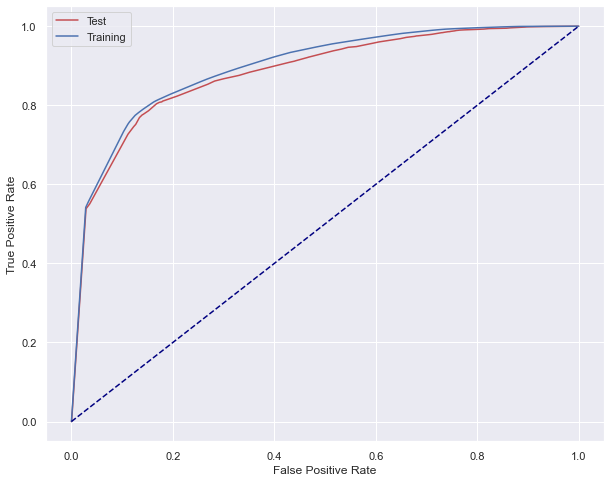

Area under the curve score: 0.883130824339173


In [100]:
def generate_probs(X, model=gs_tree_pca.best_estimator_):
    return model.predict_proba(X)[:, 1]

def generate_roc(y, probs):
    fpr, tpr, _ = roc_curve(y, probs, pos_label = 'Residential')
    return fpr, tpr
    
fpr_test, tpr_test = generate_roc(y_test, generate_probs(x_test))
fpr_train, tpr_train = generate_roc(y_train, generate_probs(x_train))

plt.figure(figsize = (10,8))
plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

print(f'Area under the curve score: {roc_auc_score(y_test, generate_probs(x_test))}')
roc_auc.append(roc_auc_score(y_test, generate_probs(x_test)))

Decision tree with PCA takes nearly 15 minutes to run and results in macro averaged precision score 77.43% on the test data. This is lower than the precision score for decision tree without PCA which was ~79% and took about 2 minutes to run. Comparing these two metrics, we conclude that decision tree without PCA is a better model. 

### **5. Random Forest**

Random forest is an ensemble model where multiple trees are trained. It is expected that running this model over a GridSearch is going to take time. I currently do not perform a secondary search as this model is taking a long time to run. 

In [69]:
%%time
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ('data_processing', Processing_pipeline),
    ('rf', RandomForestClassifier())]
)

param_grid = [{'rf__max_depth': [5, 8, 10, 12],
               'rf__n_estimators': [10, 50, 100],
               'rf__max_samples': [5000, 15000, 25000, 40000]
              }]

rf_results = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, scoring='precision_macro', refit=True)
rf_results = rf_results.fit(x_train, y_train)

rf_results.best_estimator_

Wall time: 8min 12s


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['TOTAL KWH',
                                                   'ELECTRICITY ACCOUNTS',
                                                   'ZERO KWH ACCOUNTS',
                                                   'TOTAL THERMS',
                                                   'GAS ACCOUNTS',
                                                   'KWH TOTAL SQFT',
                                                   'KWH MEAN 2010',
                                                   'KWH MINIMUM 2010

In [70]:
rf_results.best_params_

{'rf__max_depth': 12, 'rf__max_samples': 40000, 'rf__n_estimators': 100}

> The best parameters that result from the GridSearch are maximum depth of 12, maximum samples 40000 and number of estimatores 100. 

In [71]:
rf_yhat_test = rf_results.predict(x_test)
rf_yhat_train = rf_results.predict(x_test)
#evaluating the performance

print(confusion_matrix(y_test, rf_yhat_test), '\n')

print(f'Precision macro score for validation data: {rf_results.best_score_:.2%}')
print(f'Precision macro score for train data: {rf_results.score(x_train, y_train):.2%}')
print(f'Precision macro score for test data: {rf_results.score(x_test, y_test):.2%}', '\n')
print(classification_report(y_test, rf_yhat_test))

[[2357 1052]
 [ 824 9162]] 

Precision macro score for validation data: 82.34%
Precision macro score for train data: 89.55%
Precision macro score for test data: 81.90% 

                 precision    recall  f1-score   support

Non-Residential       0.74      0.69      0.72      3409
    Residential       0.90      0.92      0.91      9986

       accuracy                           0.86     13395
      macro avg       0.82      0.80      0.81     13395
   weighted avg       0.86      0.86      0.86     13395



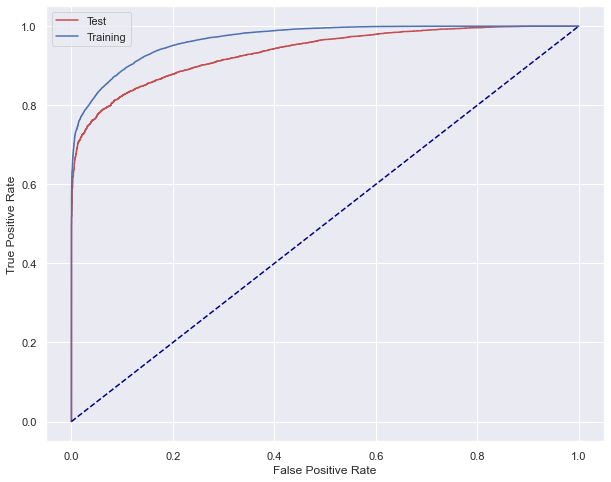

Area under the curve score: 0.9343161975607152


In [101]:
def generate_probs(X, model=rf_results.best_estimator_):
    return model.predict_proba(X)[:, 1]

def generate_roc(y, probs):
    fpr, tpr, _ = roc_curve(y, probs, pos_label = 'Residential')
    return fpr, tpr
    
fpr_test, tpr_test = generate_roc(y_test, generate_probs(x_test))
fpr_train, tpr_train = generate_roc(y_train, generate_probs(x_train))

plt.figure(figsize = (10,8))
plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

print(f'Area under the curve score: {roc_auc_score(y_test, generate_probs(x_test))}')
roc_auc.append(roc_auc_score(y_test, generate_probs(x_test)))

Random forest best model gives a precision macro score of 82.24% on the validation data and 81.84% on the test data. The f1 score is 0.81 and the roc_auc score is 0.93. therefore, as of now, the random forest models performs the best when compared to other models built so far. 

### **6. Stochastic Gradient Descent Classifier**

As my dataset seems to be large and it is taking time to perform a GridSearch using SVM, I think performing a SGD by setting loss to be 'hinge' on this dataset which is equivalent to the lienar SVM model and can be computationally more efficient. 

Reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [81]:
%%time
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score

precision = make_scorer(precision_score,zero_division=0, average = 'macro') 

sgd_pipeline = Pipeline([('data_processing', Processing_pipeline),
                          ('sgd', SGDClassifier(penalty = 'l2', loss='hinge'))])

param_grid_sgd = [{'sgd__alpha': [0.01, 0.1, 1, 10, 100, 1000]}]

sgd_results = GridSearchCV(estimator=sgd_pipeline, param_grid=param_grid_sgd, scoring=precision, refit=True, cv=6)
sgd_results = sgd_results.fit(x_train, y_train)

Wall time: 22.9 s


In [82]:
sgd_results.best_estimator_

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['TOTAL KWH',
                                                   'ELECTRICITY ACCOUNTS',
                                                   'ZERO KWH ACCOUNTS',
                                                   'TOTAL THERMS',
                                                   'GAS ACCOUNTS',
                                                   'KWH TOTAL SQFT',
                                                   'KWH MEAN 2010',
                                                   'KWH MINIMUM 2010

In [83]:
sgd_results.best_params_

{'sgd__alpha': 1}

In [88]:
sgd_pipeline_2 = Pipeline([('data_processing', Processing_pipeline),
                          ('sgd', SGDClassifier(penalty = 'l2', loss='hinge'))])

param_grid_sgd_2 = [{'sgd__alpha': [0.9,1, 1.5, 2]}]

sgd_results_2 = GridSearchCV(estimator=sgd_pipeline_2, param_grid=param_grid_sgd_2, scoring=precision, refit=True, cv=6)
sgd_results_2 = sgd_results_2.fit(x_train, y_train)
sgd_results_2.best_estimator_

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  ['TOTAL KWH',
                                                   'ELECTRICITY ACCOUNTS',
                                                   'ZERO KWH ACCOUNTS',
                                                   'TOTAL THERMS',
                                                   'GAS ACCOUNTS',
                                                   'KWH TOTAL SQFT',
                                                   'KWH MEAN 2010',
                                                   'KWH MINIMUM 2010

In [89]:
sgd_results_2.best_params_

{'sgd__alpha': 2}

In [92]:
y_hat_sgd_test_2 = sgd_results_2.predict(x_test) 
y_hat_sgd_train_2 = sgd_results_2.predict(x_train) 

# Evaluating the performance

print(confusion_matrix(y_test, y_hat_sgd_test_2), '\n')

print(f'Precision macro score for validation data: {sgd_results_2.best_score_:.2%}')
print(f'Precision macro score for train data: {sgd_results_2.score(x_train, y_train):.2%}')
print(f'Precision macro score for test data: {sgd_results_2.score(x_test, y_test):.2%}', '\n')
print(classification_report(y_test, y_hat_sgd_test_2))

[[ 530 2879]
 [  82 9904]] 

Precision macro score for validation data: 83.45%
Precision macro score for train data: 83.52%
Precision macro score for test data: 82.04% 

                 precision    recall  f1-score   support

Non-Residential       0.87      0.16      0.26      3409
    Residential       0.77      0.99      0.87      9986

       accuracy                           0.78     13395
      macro avg       0.82      0.57      0.57     13395
   weighted avg       0.80      0.78      0.72     13395



In [102]:
roc_auc.append(np.nan)

The best parameters for this model from the GridSearch is the alpha value of 1. This best model results in a precision macro score of 83% on the validation data and 81.45% for the test data. This model performs poorer than the Rnadom forest model but better than the other models we built. 

In [103]:
roc_auc

[0.903746177473338,
 0.9038135349007531,
 0.8460237115769645,
 0.883130824339173,
 0.9343161975607152,
 nan]

## Results and Discussion

Now lets compare the precision scores for the different models that we built.

In [104]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

metrics_data = {'model':['Log reg', 'Log reg with PCA', 'Decision tree', 'Decision tree with PCA', 'Random forest','SGDClassifier'], 
              'precision': [gs_lgr_no_pca_2.score(x_test, y_test),gs_lgr_2.score(x_test, y_test),gs_tree_2.score(x_test, y_test),gs_tree_pca.score(x_test, y_test), rf_results.score(x_test, y_test),sgd_results_2.score(x_test, y_test)], 
              'recall': [recall_score(y_test,y_hat_test, average = 'macro'),recall_score(y_test,y_hat_no_pca_test,average = 'macro'),recall_score(y_test, y_hat_tree_test,average = 'macro'),recall_score(y_test, y_hat_tree_pca_test,average = 'macro' ),recall_score(y_test, rf_yhat_test,average = 'macro'),recall_score(y_test, y_hat_sgd_test_2,average = 'macro')], 
              'roc_auc':roc_auc,
               'f1 score': [f1_score(y_test,y_hat_test,average = 'macro'),f1_score(y_test,y_hat_no_pca_test,average = 'macro'),f1_score(y_test, y_hat_tree_test,average = 'macro'),f1_score(y_test, y_hat_tree_pca_test,average = 'macro'),f1_score(y_test, rf_yhat_test,average = 'macro'),f1_score(y_test, y_hat_sgd_test_2,average = 'macro')], }

metrics_df = pd.DataFrame(metrics_data)

In [75]:
metrics_df.set_index('model')

,precision,recall,roc_auc,f1 score
model,,,,
Log reg,0.788265,0.743107,0.903746,0.760397
Log reg with PCA,0.787795,0.744860,0.903814,0.761797
Decision tree,0.792031,0.707478,0.846024,0.732642
Decision tree with PCA,0.775187,0.727678,0.883131,0.745383
Random forest,0.818403,0.800846,0.934253,0.808917
SGDClassifier,0.814512,0.596894,NaN,0.603268


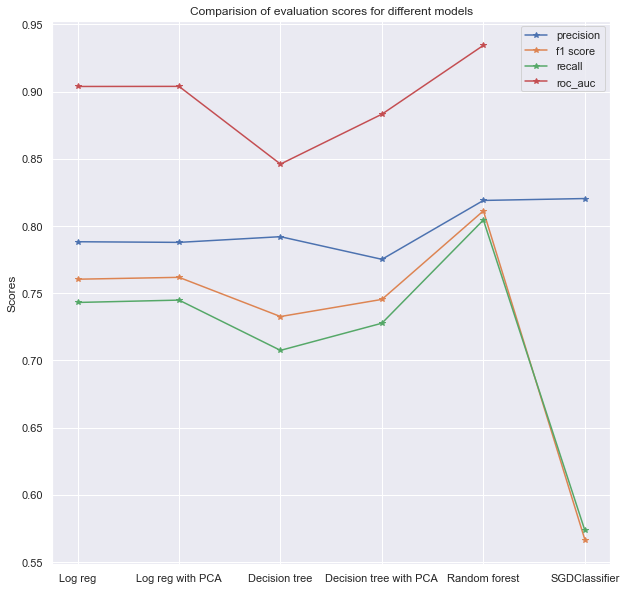

In [105]:
plt.figure(figsize=(10,10))
plt.plot(metrics_df['model'], metrics_df['precision'], '*-',label='precision')
plt.plot(metrics_df['model'], metrics_df['f1 score'], '*-',label='f1 score')
plt.plot(metrics_df['model'], metrics_df['recall'], '*-',label='recall')
plt.plot(metrics_df['model'], metrics_df['roc_auc'], '*-',label='roc_auc')
plt.legend()
plt.title('Comparision of evaluation scores for different models')
plt.ylabel('Scores')
plt.show()


> Based on the above graph comparing the scores for the different models, it is deduced that the Random forest performs better in terms of all the metrics. The logistic regression model with and without PCA perform slightly better than decision trees. The Stochastic Gradient descent is optimized for the precision amcro score and shows an improvement there but does poorly in terms of recalla nd f1 score. However, the random forest model has a disadvantage as it takes a large amount of time to run the GridSearch.

> Based on these factors, I pick Logistic regression as the best model for this classification problem. If there is more computational capability avaiilable, then one could pick the Random forest model.

The following is a comparision of the roc curves for the different models. Based on these curves, we can also conclude that Random forest performs the best for this lassification problem. 

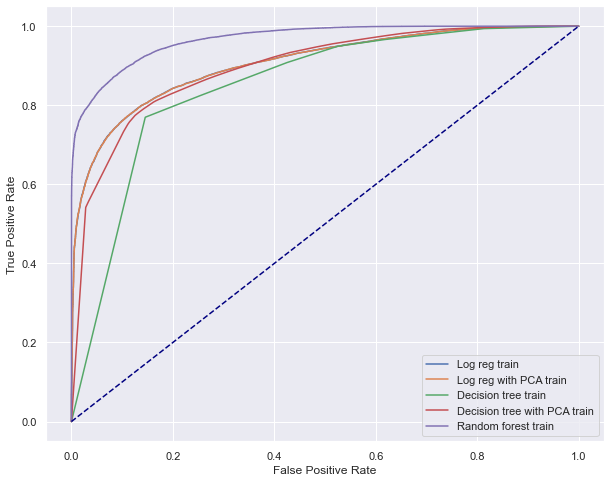

In [107]:
models = [gs_lgr_no_pca_2.best_estimator_, gs_lgr_2.best_estimator_, 
          gs_tree_2.best_estimator_, gs_tree_pca.best_estimator_, rf_results.best_estimator_]
model_names = ['Log reg', 'Log reg with PCA', 'Decision tree', 'Decision tree with PCA', 'Random forest']

plt.figure(figsize = (10,8))

i=0
for m in models:
    if i <5:
        def generate_probs(X, model=m):
            return model.predict_proba(X)[:, 1]

        def generate_roc(y, probs):
            fpr, tpr, _ = roc_curve(y, probs, pos_label = 'Residential')
            return fpr, tpr
    
        #fpr_test, tpr_test = generate_roc(y_test, generate_probs(x_test))
        fpr_train, tpr_train = generate_roc(y_train, generate_probs(x_train))
        #plt.plot(fpr_test, tpr_test,'-', label = f'{model_names[i]} test')
        plt.plot(fpr_train, tpr_train,'-', label = f'{model_names[i]} train')
        i=i+1
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

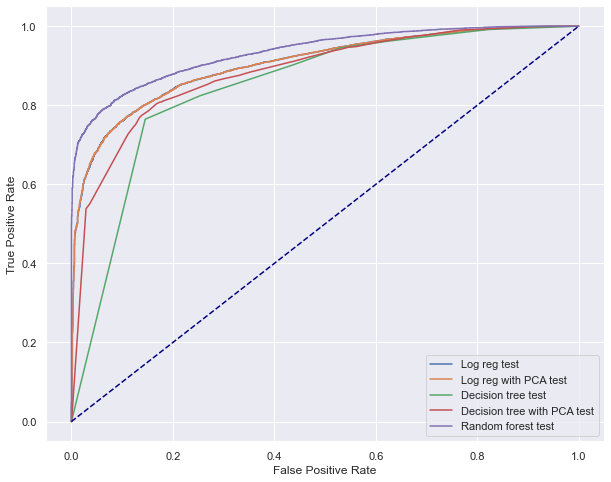

In [80]:
plt.figure(figsize = (10,8))

i=0
for m in models:
    if i <5:
        def generate_probs(X, model=m):
            return model.predict_proba(X)[:, 1]

        def generate_roc(y, probs):
            fpr, tpr, _ = roc_curve(y, probs, pos_label = 'Residential')
            return fpr, tpr
    
        fpr_test, tpr_test = generate_roc(y_test, generate_probs(x_test))
        #fpr_train, tpr_train = generate_roc(y_train, generate_probs(x_train))
        plt.plot(fpr_test, tpr_test,'-', label = f'{model_names[i]} test')
        #plt.plot(fpr_train, tpr_train,'.', label = f'{model_names[i]} train')
        i=i+1
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

## Conclusion

Based on the above modeling and analysis of evaluation metrics for the different models built, I conclude that the Logistic regression model performs better in terms of the measurement metrics and the run times. If more computational capability is available then, the Random forest model can be chosen as it shows slightly better performance.

## Next Steps

The conclusions made above are based on the modeling and analysis done here. However, the modeling process can be improved through the following ways.

1. More nuanced feature engineering to imrpove the features that are used for modeling. 
2. Pre-processing using KMeans or other methods can be implemented to check for improvement in model performance. 
3. The data considered is relatively large with nearly ~60,000 rows in the train dataset. It is important to note that GridSearch might not be very efficient when working with large datasets. Splitting the data into train, validation and test, followed by training and evaluating the models manually can be useful in reducing run times. 
4. More nuanced models such as Support Vector Machines can be used if the computational capacity exists to run them on large datasets.
5. Ensemble models where different classifiers can work together to make predictions can be used to for better performance. 




## References

1. https://machinelearningmastery.com/an-introduction-to-feature-selection/
2. https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/
3. https://towardsdatascience.com/building-classification-models-with-sklearn-6a8fd107f0c1
4. https://github.com/appliedecon/data602-lectures
5. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
